<a href="https://colab.research.google.com/github/raihanewubd/selfSupervised/blob/main/i_jepa_aav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

beautifulminnd_aav_spectrogram_path = kagglehub.dataset_download('beautifulminnd/aav-spectrogram')

print('Data source import complete.')


In [1]:
from google.colab import drive
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTImageProcessor
from collections import Counter
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
import time
from tqdm import tqdm
import torch
import timm
import matplotlib.pyplot as plt
import copy
from torchvision.models import vit_b_16
from collections import Counter
from tqdm import tqdm # for progress bar
import random
import os

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/kaggle/input/aav-spectrogram/spectrogram'
data_dir = '/content/drive/MyDrive/AAVDATASET/spectrogram'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:
# Test loading
images, labels = next(iter(dataloader))
print("Batch shape:", images.shape)  # Should be [B, C, 224, 224]

Batch shape: torch.Size([16, 3, 224, 224])


In [5]:
batch_size = 32
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(6):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze(), cmap='viridis')
    plt.axis('off')
plt.suptitle("Sample Spectrograms (Resized to 224×224)")
plt.tight_layout()
plt.show()

In [ ]:


def count_images_per_class(train_loader):
    """Counts the number of images per class in a train_loader.

    Args:
        train_loader: The DataLoader for the training dataset.

    Returns:
        A dictionary where keys are class labels and values are the corresponding counts.
    """

    all_labels = []
    for images, labels in tqdm(train_loader, desc="Counting images per class"):
        all_labels.extend(labels.tolist())  # Extend the list with labels from the batch

    class_counts = Counter(all_labels)  # Count occurrences of each label

    return class_counts

In [ ]:
# Get the counts and print them
class_counts = count_images_per_class(train_loader)

print("Images per class in train_loader:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

In [ ]:
# Get the counts and print them
class_counts = count_images_per_class(val_loader)

print("Images per class in train_loader:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

In [6]:
def extract_blocks(image, context_scale=0.85, target_scale=0.2, num_targets=4, max_overlap=0.5):
    # Extract a central context block.
    _, H, W = image.shape
    context_size = int(context_scale * H)
    top = (H - context_size) // 2
    left = (W - context_size) // 2
    context_block = image[:, top:top+context_size, left:left+context_size]
    context_block = torch.nn.functional.interpolate(context_block.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

    # Extract num_targets target blocks randomly.
    target_blocks = []
    for _ in range(num_targets):
        target_size = int(target_scale * H)
        top_t = random.randint(0, H - target_size)
        left_t = random.randint(0, W - target_size)
        target_block = image[:, top_t:top_t+target_size, left_t:left_t+target_size]
        target_block = torch.nn.functional.interpolate(target_block.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        target_blocks.append(target_block)
    target_blocks = torch.stack(target_blocks)
    return context_block, target_blocks, (top, left, context_size), None

In [7]:
class IJEPADataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, context_scale=0.85, target_scale=0.2, num_targets=4):
        self.base_dataset = base_dataset
        self.context_scale = context_scale
        self.target_scale = target_scale
        self.num_targets = num_targets

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        context_block, target_blocks, _, _ = extract_blocks(image, self.context_scale, self.target_scale, self.num_targets)
        return context_block, target_blocks, label

In [8]:
train_ijepa_dataset = IJEPADataset(train_dataset)
val_ijepa_dataset   = IJEPADataset(val_dataset)


train_loader = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_ijepa_dataset, batch_size=32, shuffle=False)

# Compare Direct Loading vs Preprossed blocks

In [12]:
n_samples = 100
extract_times = []
for i in range(n_samples):
    img, label = train_dataset[i]  # Assumes train_base_dataset is already defined.
    start = time.perf_counter()
    # Call the extraction function (adjust parameters as needed)
    context_block, target_blocks, _, _ = extract_blocks(img, context_scale=0.85, target_scale=0.2, num_targets=4)
    end = time.perf_counter()
    extract_times.append(end - start)

avg_extract_time = sum(extract_times) / len(extract_times)
print(f"Average extract_blocks time over {n_samples} samples: {avg_extract_time:.6f} seconds")

Average extract_blocks time over 100 samples: 0.002441 seconds


In [9]:
import time
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import os

# Assume extract_blocks and train_base_dataset are defined.

class PrecomputedIJEPADataset(Dataset):
    def __init__(self, base_dataset, context_scale=0.85, target_scale=0.2, num_targets=4, cache_file=None):
        self.cache_file = cache_file
        if cache_file and os.path.exists(cache_file):
            # Load precomputed data from disk.
            with open(cache_file, 'rb') as f:
                self.data = pickle.load(f)
        else:
            self.data = []
            for img, label in base_dataset:
                context_block, target_blocks, _, _ = extract_blocks(img, context_scale, target_scale, num_targets)
                self.data.append((context_block, target_blocks, label))
            if cache_file:
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.data, f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Timing the loading of the dataset and DataLoader
cache_path = 'precomputed_aav.pkl'
start_time = time.time()

train_ijepa_dataset = PrecomputedIJEPADataset(train_dataset, cache_file=cache_path)
end_time_train_ijepa_dataset = time.time()
train_loader = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=True)

end_time = time.time()
print(f"Time taken to load dataset: {end_time_train_ijepa_dataset - start_time:.4f} seconds and DataLoader: {end_time - start_time:.4f} seconds")


Time taken to load dataset: 2246.4051 seconds and DataLoader: 2246.4054 seconds


In [10]:
import time
import pickle
import os
# ----- Measure cache file reading time -----
cache_path = 'precomputed_aav.pkl'
read_times = []
n_reads = 10  # Number of times to load the cache file.

for i in range(n_reads):
    start = time.perf_counter()
    with open(cache_path, 'rb') as f:
        data = pickle.load(f)
    end = time.perf_counter()
    read_times.append(end - start)

avg_read_time = sum(read_times) / len(read_times)
print(f"Average time to load cache file over {n_reads} runs: {avg_read_time:.6f} seconds")

Average time to load cache file over 10 runs: 5.557618 seconds


In [11]:
# Timing the loading of the dataset and DataLoader
cache_path = 'precomputed_aav.pkl'
start_time = time.time()

train_ijepa_dataset = PrecomputedIJEPADataset(train_dataset, cache_file=cache_path)
end_time_train_ijepa_dataset = time.time()
train_loader = DataLoader(train_ijepa_dataset, batch_size=32, shuffle=True)

end_time = time.time()
print(f"Time taken to load dataset: {end_time_train_ijepa_dataset - start_time:.4f} seconds and DataLoader: {end_time - start_time:.4f} seconds")

Time taken to load dataset: 4.4704 seconds and DataLoader: 4.4706 seconds


In [12]:
n_samples = 100
extract_times = []
for i in range(n_samples):
    start = time.perf_counter()
    context_block, target_blocks, label = train_ijepa_dataset[i]  # Assumes train_base_dataset is already defined.

    # Call the extraction function (adjust parameters as needed)
    #context_block, target_blocks, _, _ = extract_blocks(img, context_scale=0.85, target_scale=0.2, num_targets=4)
    end = time.perf_counter()
    extract_times.append(end - start)

avg_extract_time = sum(extract_times) / len(extract_times)
print(f"Average extract_blocks time over {n_samples} samples: {avg_extract_time:.6f} seconds")

Average extract_blocks time over 100 samples: 0.000001 seconds


In [13]:
def get_vit_encoder():
    model = vit_b_16(pretrained=False)
    model.heads = nn.Identity()  # remove classification head
    return model

In [14]:

context_encoder = get_vit_encoder().cuda()
target_encoder  = get_vit_encoder().cuda()
target_encoder.load_state_dict(context_encoder.state_dict())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [15]:
class Predictor(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=768, output_dim=768, num_targets=4):
        super().__init__()
        self.num_targets = num_targets
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_targets)
        )
    def forward(self, context_repr):
        pred = self.mlp(context_repr)
        # Reshape to [B, num_targets, output_dim]
        return pred.view(-1, self.num_targets, pred.size(-1) // self.num_targets)

In [16]:
# 6. Set up optimizer, loss, and EMA update (same as your CIFAR code).
predictor = Predictor().cuda()
optimizer = optim.Adam(list(context_encoder.parameters()) + list(predictor.parameters()), lr=1e-3)
criterion = nn.MSELoss()
ema_decay = 0.99

In [17]:
@torch.no_grad()
def update_ema(model, model_ema, beta):
    for param, param_ema in zip(model.parameters(), model_ema.parameters()):
        param_ema.data.mul_(beta).add_(param.data, alpha=1 - beta)

In [20]:
# Create a directory for visualizations if it doesn't exist.
#viz_dir = "/kaggle/working/viz"
#os.makedirs(viz_dir, exist_ok=True)

num_epochs = 100
ema_decay = 0.99
best_loss = float('inf')
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    context_encoder.train()
    predictor.train()
    running_loss = 0.0

    # Enumerate over batches with a progress bar.
    for batch_idx, (context_block, target_blocks, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        context_block = context_block.cuda()            # [B, C, 224, 224]
        target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]

        # Forward pass through context encoder and predictor.
        context_repr = context_encoder(context_block)     # [B, 768]
        preds = predictor(context_repr)                   # [B, num_targets, 768]

        B, num_targets, C, Ht, Wt = target_blocks.shape
        target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
        with torch.no_grad():
            target_repr_flat = target_encoder(target_blocks_flat)
        target_repr = target_repr_flat.view(B, num_targets, -1)

        loss = criterion(preds, target_repr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(context_encoder, target_encoder, ema_decay)
        running_loss += loss.item() * context_block.size(0)

        # --- Visualization for first image of the current batch ---
        '''with torch.no_grad():
            # Get the first sample's context block and compute its feature vector.
            context_img = context_block[0].cpu()  # shape: [C, 224, 224]
            context_feat = context_encoder(context_block[0].unsqueeze(0)).cpu().squeeze(0)  # shape: [768]
            # Reshape feature vector to a 2D heatmap (24x32).
            context_heat = context_feat.view(24, 32).numpy()

            # For target, choose the first target block of the first sample.
            target_img = target_blocks[0][0].cpu()  # shape: [C, 224, 224]
            target_feat = target_encoder(target_blocks[0][0].unsqueeze(0).to(context_block.device)).cpu().squeeze(0)
            target_heat = target_feat.view(24, 32).numpy()

            # Plot the images and corresponding heatmaps.
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))

            # Display context block image.
            if context_img.shape[0] == 1:
                axs[0, 0].imshow(context_img.squeeze(), cmap='gray')
            else:
                axs[0, 0].imshow(context_img.permute(1, 2, 0))
            axs[0, 0].set_title("Context Block")
            axs[0, 0].axis("off")

            # Display context feature heatmap.
            im0 = axs[0, 1].imshow(context_heat, cmap="viridis")
            axs[0, 1].set_title("Context Feature Heatmap")
            axs[0, 1].axis("off")
            fig.colorbar(im0, ax=axs[0, 1])

            # Display target block image.
            if target_img.shape[0] == 1:
                axs[1, 0].imshow(target_img.squeeze(), cmap='gray')
            else:
                axs[1, 0].imshow(target_img.permute(1, 2, 0))
            axs[1, 0].set_title("Target Block")
            axs[1, 0].axis("off")

            # Display target feature heatmap.
            im1 = axs[1, 1].imshow(target_heat, cmap="viridis")
            axs[1, 1].set_title("Target Feature Heatmap")
            axs[1, 1].axis("off")
            fig.colorbar(im1, ax=axs[1, 1])

            # Save the visualization figure with epoch and batch number.
            viz_path = os.path.join(viz_dir, f"epoch{epoch+1}_batch{batch_idx+1}.png")
            plt.savefig(viz_path)
            plt.close(fig)'''

    epoch_loss = running_loss / len(train_ijepa_dataset)
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.10f} - Epoch Time: {epoch_time:.2f}s")

    # Save checkpoint if current epoch loss is lower than previous best.
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            'epoch': epoch+1,
            'context_encoder_state_dict': context_encoder.state_dict(),
            'target_encoder_state_dict': target_encoder.state_dict(),
            'predictor_state_dict': predictor.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }
        torch.save(checkpoint, "/content/drive/MyDrive/AAVDATASET/spectrogram/ijepa_checkpoint_best.pth")
        print(f"Checkpoint saved at epoch {epoch+1} with loss {epoch_loss:.4f}")


total_train_time = time.time() - total_start_time
print(f"Total Training Time: {total_train_time:.2f}s")

KeyboardInterrupt: 

# Grid Search EMA Decay


Training with ema_decay = 0.1


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ema_decay=0.1, Epoch 1/10 - Loss: 0.0784310110 - Epoch Time: 46.16s


ema_decay=0.1, Epoch 2/10 - Loss: 0.0000022074 - Epoch Time: 46.13s


ema_decay=0.1, Epoch 3/10 - Loss: 0.0000003072 - Epoch Time: 46.11s


ema_decay=0.1, Epoch 4/10 - Loss: 0.0004379737 - Epoch Time: 46.14s


ema_decay=0.1, Epoch 5/10 - Loss: 0.0000003881 - Epoch Time: 46.12s


ema_decay=0.1, Epoch 6/10 - Loss: 0.0000002436 - Epoch Time: 46.13s


ema_decay=0.1, Epoch 7/10 - Loss: 0.0003283348 - Epoch Time: 46.12s


ema_decay=0.1, Epoch 8/10 - Loss: 0.0000008968 - Epoch Time: 46.13s


ema_decay=0.1, Epoch 9/10 - Loss: 0.0000002289 - Epoch Time: 46.18s


ema_decay=0.1, Epoch 10/10 - Loss: 0.0001838212 - Epoch Time: 46.13s
Candidate ema_decay = 0.1 achieved best loss: 0.0000002289

Training with ema_decay = 0.3


ema_decay=0.3, Epoch 1/10 - Loss: 0.0700226839 - Epoch Time: 46.13s


ema_decay=0.3, Epoch 2/10 - Loss: 0.0004385214 - Epoch Time: 46.09s


ema_decay=0.3, Epoch 3/10 - Loss: 0.0000645120 - Epoch Time: 46.10s


ema_decay=0.3, Epoch 4/10 - Loss: 0.0000002573 - Epoch Time: 46.13s


ema_decay=0.3, Epoch 5/10 - Loss: 0.0006256667 - Epoch Time: 46.12s


ema_decay=0.3, Epoch 6/10 - Loss: 0.0000011275 - Epoch Time: 46.10s


ema_decay=0.3, Epoch 7/10 - Loss: 0.0000002301 - Epoch Time: 46.11s


ema_decay=0.3, Epoch 8/10 - Loss: 0.0000002313 - Epoch Time: 46.12s


ema_decay=0.3, Epoch 9/10 - Loss: 0.0001898884 - Epoch Time: 46.11s


ema_decay=0.3, Epoch 10/10 - Loss: 0.0000863488 - Epoch Time: 46.07s
Candidate ema_decay = 0.3 achieved best loss: 0.0000002301

Training with ema_decay = 0.5


ema_decay=0.5, Epoch 1/10 - Loss: 0.0675618922 - Epoch Time: 46.14s


ema_decay=0.5, Epoch 2/10 - Loss: 0.0002461277 - Epoch Time: 46.11s


ema_decay=0.5, Epoch 3/10 - Loss: 0.0002542916 - Epoch Time: 46.10s


ema_decay=0.5, Epoch 4/10 - Loss: 0.0004119619 - Epoch Time: 46.12s


ema_decay=0.5, Epoch 5/10 - Loss: 0.0000006873 - Epoch Time: 46.12s


ema_decay=0.5, Epoch 6/10 - Loss: 0.0004438784 - Epoch Time: 46.13s


ema_decay=0.5, Epoch 7/10 - Loss: 0.0000712131 - Epoch Time: 46.11s


ema_decay=0.5, Epoch 8/10 - Loss: 0.0000003021 - Epoch Time: 46.12s


ema_decay=0.5, Epoch 9/10 - Loss: 0.0000002980 - Epoch Time: 46.12s


ema_decay=0.5, Epoch 10/10 - Loss: 0.0000003078 - Epoch Time: 46.11s
Candidate ema_decay = 0.5 achieved best loss: 0.0000002980

Training with ema_decay = 0.7


ema_decay=0.7, Epoch 1/10 - Loss: 0.0688861864 - Epoch Time: 46.16s


ema_decay=0.7, Epoch 2/10 - Loss: 0.0007176568 - Epoch Time: 46.13s


ema_decay=0.7, Epoch 3/10 - Loss: 0.0000073857 - Epoch Time: 46.14s


ema_decay=0.7, Epoch 4/10 - Loss: 0.0004270519 - Epoch Time: 46.14s


ema_decay=0.7, Epoch 5/10 - Loss: 0.0000394836 - Epoch Time: 46.13s


ema_decay=0.7, Epoch 6/10 - Loss: 0.0000004578 - Epoch Time: 46.07s


ema_decay=0.7, Epoch 7/10 - Loss: 0.0004078798 - Epoch Time: 46.11s


ema_decay=0.7, Epoch 8/10 - Loss: 0.0000036086 - Epoch Time: 46.11s


ema_decay=0.7, Epoch 9/10 - Loss: 0.0000003904 - Epoch Time: 46.10s


ema_decay=0.7, Epoch 10/10 - Loss: 0.0000162674 - Epoch Time: 46.13s
Candidate ema_decay = 0.7 achieved best loss: 0.0000003904

Training with ema_decay = 0.95


ema_decay=0.95, Epoch 1/10 - Loss: 0.0639305694 - Epoch Time: 46.16s


ema_decay=0.95, Epoch 2/10 - Loss: 0.0000024178 - Epoch Time: 46.13s


ema_decay=0.95, Epoch 3/10 - Loss: 0.0000003071 - Epoch Time: 46.14s


ema_decay=0.95, Epoch 4/10 - Loss: 0.0004783561 - Epoch Time: 46.11s


ema_decay=0.95, Epoch 5/10 - Loss: 0.0000235722 - Epoch Time: 46.12s


ema_decay=0.95, Epoch 6/10 - Loss: 0.0000003004 - Epoch Time: 46.13s


ema_decay=0.95, Epoch 7/10 - Loss: 0.0003493669 - Epoch Time: 46.11s


ema_decay=0.95, Epoch 8/10 - Loss: 0.0000157483 - Epoch Time: 46.10s


ema_decay=0.95, Epoch 9/10 - Loss: 0.0000002845 - Epoch Time: 46.14s


ema_decay=0.95, Epoch 10/10 - Loss: 0.0001868156 - Epoch Time: 46.14s
Candidate ema_decay = 0.95 achieved best loss: 0.0000002845

Training with ema_decay = 0.97


ema_decay=0.97, Epoch 1/10 - Loss: 0.0612728220 - Epoch Time: 46.15s


ema_decay=0.97, Epoch 2/10 - Loss: 0.0004886564 - Epoch Time: 46.11s


ema_decay=0.97, Epoch 3/10 - Loss: 0.0005727063 - Epoch Time: 46.11s


ema_decay=0.97, Epoch 4/10 - Loss: 0.0000440036 - Epoch Time: 46.08s


ema_decay=0.97, Epoch 5/10 - Loss: 0.0000006971 - Epoch Time: 46.12s


ema_decay=0.97, Epoch 6/10 - Loss: 0.0003727488 - Epoch Time: 46.13s


ema_decay=0.97, Epoch 7/10 - Loss: 0.0000091222 - Epoch Time: 46.10s


ema_decay=0.97, Epoch 8/10 - Loss: 0.0000006807 - Epoch Time: 46.17s


ema_decay=0.97, Epoch 9/10 - Loss: 0.0003711778 - Epoch Time: 46.06s


ema_decay=0.97, Epoch 10/10 - Loss: 0.0000093919 - Epoch Time: 46.10s
Candidate ema_decay = 0.97 achieved best loss: 0.0000006807

Training with ema_decay = 0.99


ema_decay=0.99, Epoch 1/10 - Loss: 0.0576062427 - Epoch Time: 46.14s


ema_decay=0.99, Epoch 2/10 - Loss: 0.0003909118 - Epoch Time: 46.14s


ema_decay=0.99, Epoch 3/10 - Loss: 0.0003433895 - Epoch Time: 46.18s


ema_decay=0.99, Epoch 4/10 - Loss: 0.0000127078 - Epoch Time: 46.12s


ema_decay=0.99, Epoch 5/10 - Loss: 0.0004761853 - Epoch Time: 46.09s


ema_decay=0.99, Epoch 6/10 - Loss: 0.0000064072 - Epoch Time: 46.07s


ema_decay=0.99, Epoch 7/10 - Loss: 0.0000007598 - Epoch Time: 46.12s


ema_decay=0.99, Epoch 8/10 - Loss: 0.0000858958 - Epoch Time: 46.13s


ema_decay=0.99, Epoch 9/10 - Loss: 0.0000210222 - Epoch Time: 46.16s


ema_decay=0.99, Epoch 10/10 - Loss: 0.0003163939 - Epoch Time: 46.12s
Candidate ema_decay = 0.99 achieved best loss: 0.0000007598

Training with ema_decay = 0.999


ema_decay=0.999, Epoch 1/10 - Loss: 0.0524903805 - Epoch Time: 46.13s


ema_decay=0.999, Epoch 2/10 - Loss: 0.0008814383 - Epoch Time: 46.11s


ema_decay=0.999, Epoch 3/10 - Loss: 0.0000694917 - Epoch Time: 46.09s


ema_decay=0.999, Epoch 4/10 - Loss: 0.0002007506 - Epoch Time: 46.15s


ema_decay=0.999, Epoch 5/10 - Loss: 0.0001751897 - Epoch Time: 46.07s


ema_decay=0.999, Epoch 6/10 - Loss: 0.0004407998 - Epoch Time: 46.12s


ema_decay=0.999, Epoch 7/10 - Loss: 0.0000127813 - Epoch Time: 46.13s


ema_decay=0.999, Epoch 8/10 - Loss: 0.0000065032 - Epoch Time: 46.13s


ema_decay=0.999, Epoch 9/10 - Loss: 0.0000053758 - Epoch Time: 46.12s


ema_decay=0.999, Epoch 10/10 - Loss: 0.0003105117 - Epoch Time: 46.11s
Candidate ema_decay = 0.999 achieved best loss: 0.0000053758

Grid Search Results:
ema_decay 0.1: Best Loss = 0.0000002289
ema_decay 0.3: Best Loss = 0.0000002301
ema_decay 0.5: Best Loss = 0.0000002980
ema_decay 0.7: Best Loss = 0.0000003904
ema_decay 0.95: Best Loss = 0.0000002845
ema_decay 0.97: Best Loss = 0.0000006807
ema_decay 0.99: Best Loss = 0.0000007598
ema_decay 0.999: Best Loss = 0.0000053758


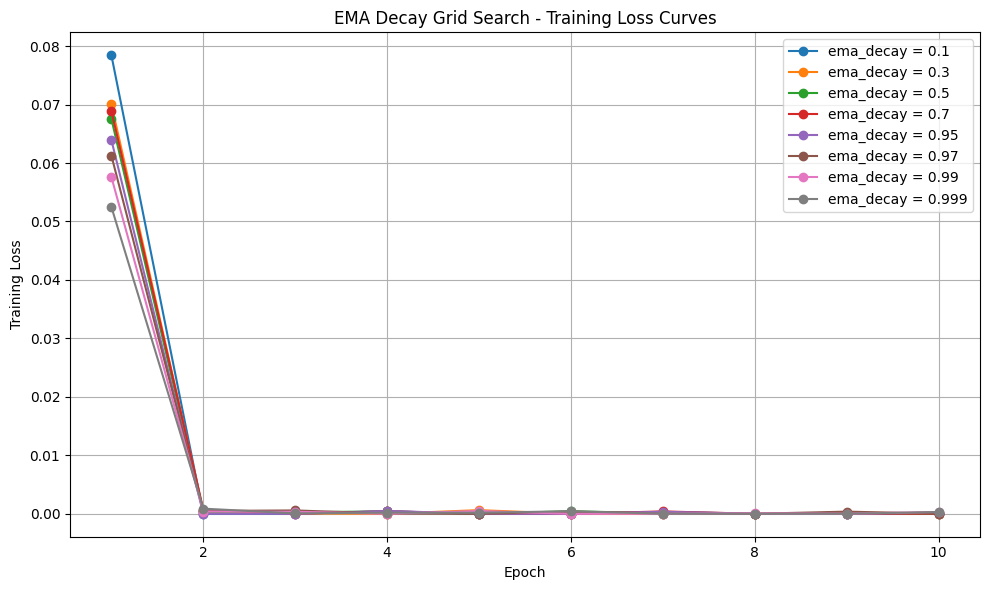

In [22]:
import os
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define candidate EMA decay values.
ema_decay_candidates = [0.1, 0.3, 0.5, 0.7, 0.95, 0.97, 0.99, 0.999]
num_epochs_grid = 10  # Use fewer epochs for grid search.
grid_results = {}      # To record the best loss for each candidate.
training_curves = {}   # To store epoch loss curves for each candidate.

# Loop over each EMA decay candidate.
for candidate in ema_decay_candidates:
    print(f"\nTraining with ema_decay = {candidate}")

    # Reinitialize models for each candidate.
    context_encoder_candidate = get_vit_encoder().cuda()
    target_encoder_candidate = get_vit_encoder().cuda()
    target_encoder_candidate.load_state_dict(context_encoder_candidate.state_dict())
    predictor_candidate = Predictor().cuda()

    # Set up a new optimizer.
    optimizer_candidate = torch.optim.Adam(
        list(context_encoder_candidate.parameters()) + list(predictor_candidate.parameters()),
        lr=1e-3
    )

    best_loss_candidate = float('inf')
    candidate_losses = []  # To store epoch losses for this candidate.

    for epoch in range(num_epochs_grid):
        context_encoder_candidate.train()
        predictor_candidate.train()
        running_loss = 0.0
        epoch_start_time = time.time()

        for batch_idx, (context_block, target_blocks, _) in enumerate(
            tqdm(train_loader, desc=f"Candidate {candidate} Epoch {epoch+1}/{num_epochs_grid}", leave=False)
        ):
            context_block = context_block.cuda()            # [B, C, 224, 224]
            target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]

            # Forward pass.
            context_repr = context_encoder_candidate(context_block)  # [B, 768]
            preds = predictor_candidate(context_repr)                # [B, num_targets, 768]

            B, num_targets, C, Ht, Wt = target_blocks.shape
            target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
            with torch.no_grad():
                target_repr_flat = target_encoder_candidate(target_blocks_flat)
            target_repr = target_repr_flat.view(B, num_targets, -1)

            loss = criterion(preds, target_repr)
            optimizer_candidate.zero_grad()
            loss.backward()
            optimizer_candidate.step()

            # Update target encoder with the candidate's EMA decay.
            update_ema(context_encoder_candidate, target_encoder_candidate, candidate)

            running_loss += loss.item() * context_block.size(0)

        epoch_loss = running_loss / len(train_ijepa_dataset)
        candidate_losses.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        print(f"ema_decay={candidate}, Epoch {epoch+1}/{num_epochs_grid} - Loss: {epoch_loss:.10f} - Epoch Time: {epoch_time:.2f}s")

        if epoch_loss < best_loss_candidate:
            best_loss_candidate = epoch_loss

    training_curves[candidate] = candidate_losses
    grid_results[candidate] = best_loss_candidate
    print(f"Candidate ema_decay = {candidate} achieved best loss: {best_loss_candidate:.10f}")

# Print grid search results.
print("\nGrid Search Results:")
for candidate, loss in grid_results.items():
    print(f"ema_decay {candidate}: Best Loss = {loss:.10f}")

# ---------------------------
# Plot learning curves for all EMA decay candidates.
# ---------------------------
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs_grid + 1)
for candidate, losses in training_curves.items():
    plt.plot(epochs, losses, marker='o', label=f"ema_decay = {candidate}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("EMA Decay Grid Search - Training Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AAVDATASET/spectrogram/ema_decay_grid_search.png")
plt.show()


# Grid Search of learning rate for the best EMA decay


Training with learning rate = 0.0001


LR 0.0001, Epoch 1/10 - Loss: 0.498063963439541 - Epoch Time: 46.14s


LR 0.0001, Epoch 2/10 - Loss: 0.014219712249080 - Epoch Time: 46.11s


LR 0.0001, Epoch 3/10 - Loss: 0.000540569737614 - Epoch Time: 46.12s


LR 0.0001, Epoch 4/10 - Loss: 0.000160704426655 - Epoch Time: 46.12s


LR 0.0001, Epoch 5/10 - Loss: 0.000124237333110 - Epoch Time: 46.11s


LR 0.0001, Epoch 6/10 - Loss: 0.000136127216958 - Epoch Time: 46.12s


LR 0.0001, Epoch 7/10 - Loss: 0.000239846976685 - Epoch Time: 46.12s


LR 0.0001, Epoch 8/10 - Loss: 0.000641506814706 - Epoch Time: 46.13s


LR 0.0001, Epoch 9/10 - Loss: 0.001284850918517 - Epoch Time: 46.15s


LR 0.0001, Epoch 10/10 - Loss: 0.000487358888526 - Epoch Time: 46.13s
Candidate lr = 0.0001 achieved best loss: 0.000124237333110

Training with learning rate = 0.001


LR 0.001, Epoch 1/10 - Loss: 0.072202424068591 - Epoch Time: 46.16s


LR 0.001, Epoch 2/10 - Loss: 0.000551784663904 - Epoch Time: 46.10s


LR 0.001, Epoch 3/10 - Loss: 0.000002770265308 - Epoch Time: 46.11s


LR 0.001, Epoch 4/10 - Loss: 0.000492774643466 - Epoch Time: 46.09s


LR 0.001, Epoch 5/10 - Loss: 0.000040934064353 - Epoch Time: 46.13s


LR 0.001, Epoch 6/10 - Loss: 0.000000229584469 - Epoch Time: 46.12s


LR 0.001, Epoch 7/10 - Loss: 0.000000230804334 - Epoch Time: 46.10s


LR 0.001, Epoch 8/10 - Loss: 0.000440038617076 - Epoch Time: 46.12s


LR 0.001, Epoch 9/10 - Loss: 0.000005090014799 - Epoch Time: 46.11s


LR 0.001, Epoch 10/10 - Loss: 0.000000230879737 - Epoch Time: 46.11s
Candidate lr = 0.001 achieved best loss: 0.000000229584469

Training with learning rate = 0.01


LR 0.01, Epoch 1/10 - Loss: 4.794489257405547 - Epoch Time: 46.18s


LR 0.01, Epoch 2/10 - Loss: 0.000509592689505 - Epoch Time: 46.14s


LR 0.01, Epoch 3/10 - Loss: 0.000404409178069 - Epoch Time: 46.14s


LR 0.01, Epoch 4/10 - Loss: 0.000519562512666 - Epoch Time: 46.13s


LR 0.01, Epoch 5/10 - Loss: 0.000000080805028 - Epoch Time: 46.13s


LR 0.01, Epoch 6/10 - Loss: 0.001388133084067 - Epoch Time: 46.12s


LR 0.01, Epoch 7/10 - Loss: 0.000003924084707 - Epoch Time: 46.13s


LR 0.01, Epoch 8/10 - Loss: 0.000000021398943 - Epoch Time: 46.13s


LR 0.01, Epoch 9/10 - Loss: 0.002202777306152 - Epoch Time: 46.14s


LR 0.01, Epoch 10/10 - Loss: 0.000003295848366 - Epoch Time: 46.14s
Candidate lr = 0.01 achieved best loss: 0.000000021398943

Training with learning rate = 0.1


LR 0.1, Epoch 1/10 - Loss: 203713.621873604453867 - Epoch Time: 46.18s


LR 0.1, Epoch 2/10 - Loss: 1.207524002407797 - Epoch Time: 46.13s


LR 0.1, Epoch 3/10 - Loss: 0.000269088017088 - Epoch Time: 46.15s


LR 0.1, Epoch 4/10 - Loss: 0.000131968522193 - Epoch Time: 46.09s


LR 0.1, Epoch 5/10 - Loss: 0.000148296969008 - Epoch Time: 46.13s


LR 0.1, Epoch 6/10 - Loss: 0.000132987314694 - Epoch Time: 46.08s


LR 0.1, Epoch 7/10 - Loss: 0.000136187865021 - Epoch Time: 46.12s


LR 0.1, Epoch 8/10 - Loss: 0.000139452444604 - Epoch Time: 46.14s


LR 0.1, Epoch 9/10 - Loss: 0.000142599534354 - Epoch Time: 46.15s


LR 0.1, Epoch 10/10 - Loss: 0.000137863225002 - Epoch Time: 46.12s
Candidate lr = 0.1 achieved best loss: 0.000131968522193

Grid Search Results:
Learning Rate 0.0001: Best Loss = 0.000124237333110
Learning Rate 0.001: Best Loss = 0.000000229584469
Learning Rate 0.01: Best Loss = 0.000000021398943
Learning Rate 0.1: Best Loss = 0.000131968522193


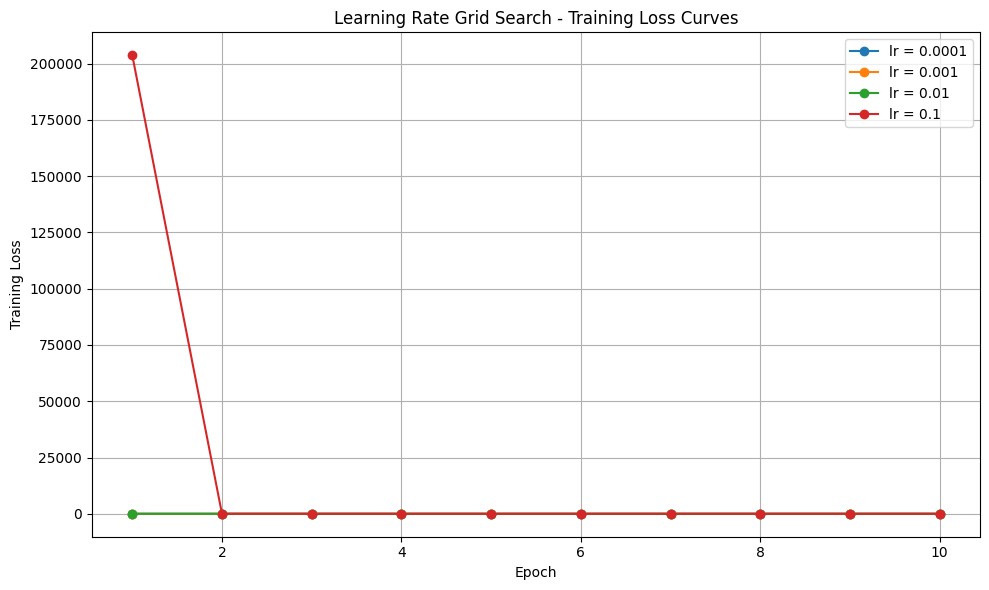

In [25]:
import os
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define candidate learning rate values.
lr_candidates = [1e-4, 1e-3, 1e-2, 1e-1]
num_epochs_grid = 10  # Use a smaller number of epochs for the grid search.
grid_results = {}      # To record the best loss for each candidate.
training_curves = {}   # To store per-epoch loss curves for each candidate.

# Loop over each learning rate candidate.
for lr in lr_candidates:
    print(f"\nTraining with learning rate = {lr}")

    # Reinitialize models for each candidate.
    context_encoder_candidate = get_vit_encoder().cuda()
    target_encoder_candidate = get_vit_encoder().cuda()
    target_encoder_candidate.load_state_dict(context_encoder_candidate.state_dict())
    predictor_candidate = Predictor().cuda()

    # Set up a new optimizer with the current learning rate.
    optimizer_candidate = torch.optim.Adam(
        list(context_encoder_candidate.parameters()) + list(predictor_candidate.parameters()),
        lr=lr
    )

    best_loss_candidate = float('inf')
    candidate_losses = []  # To store the epoch loss for this candidate.

    for epoch in range(num_epochs_grid):
        context_encoder_candidate.train()
        predictor_candidate.train()
        running_loss = 0.0
        epoch_start_time = time.time()

        for batch_idx, (context_block, target_blocks, _) in enumerate(
            tqdm(train_loader, desc=f"LR {lr} Epoch {epoch+1}/{num_epochs_grid}", leave=False)
        ):
            context_block = context_block.cuda()            # [B, C, 224, 224]
            target_blocks = target_blocks.cuda()              # [B, num_targets, C, 224, 224]

            # Forward pass.
            context_repr = context_encoder_candidate(context_block)  # [B, 768]
            preds = predictor_candidate(context_repr)                # [B, num_targets, 768]

            B, num_targets, C, Ht, Wt = target_blocks.shape
            target_blocks_flat = target_blocks.view(B * num_targets, C, Ht, Wt)
            with torch.no_grad():
                target_repr_flat = target_encoder_candidate(target_blocks_flat)
            target_repr = target_repr_flat.view(B, num_targets, -1)

            loss = criterion(preds, target_repr)
            optimizer_candidate.zero_grad()
            loss.backward()
            optimizer_candidate.step()

            # For this grid search over learning rate, we keep the EMA update constant (e.g. using a fixed value).
            update_ema(context_encoder_candidate, target_encoder_candidate, 0.1)

            running_loss += loss.item() * context_block.size(0)

        epoch_loss = running_loss / len(train_ijepa_dataset)
        candidate_losses.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        print(f"LR {lr}, Epoch {epoch+1}/{num_epochs_grid} - Loss: {epoch_loss:.15f} - Epoch Time: {epoch_time:.2f}s")

        if epoch_loss < best_loss_candidate:
            best_loss_candidate = epoch_loss

    training_curves[lr] = candidate_losses
    grid_results[lr] = best_loss_candidate
    print(f"Candidate lr = {lr} achieved best loss: {best_loss_candidate:.15f}")

# Print grid search results.
print("\nGrid Search Results:")
for candidate, loss in grid_results.items():
    print(f"Learning Rate {candidate}: Best Loss = {loss:.15f}")

# ---------------------------
# Plot learning curves for all learning rate candidates.
# ---------------------------
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs_grid + 1)
for lr, losses in training_curves.items():
    plt.plot(epochs, losses, marker='o', label=f"lr = {lr}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Learning Rate Grid Search - Training Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AAVDATASET/spectrogram/learning_rate_grid_search.png")
plt.show()


In [ ]:
from google.colab import output
output.eval_js('google.colab.kernel.disconnect()')

In [ ]:
!kill -9 -1